# Premiere question : Dans les XSF les angles du pitch sont donnés par rapport à la verticale. Comment valider la transformation repère antenne vers repère navire. Ou autre question, comment ces angles sont calculés par le sondeur 



In [7]:
%matplotlib inline

In [8]:
import sys
sys.executable

'C:\\Tools\\Anaconda3\\envs\\pyat_dev\\python.exe'

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pyat.core.xsf.xsf_constants as cst
from pyat.playground.stage.utils.time_utils import secondToNanoF, nano_todatetime, floatsecond_tonano_array
from pyat.core.xsf.xsf_reader import XSFReader

plt.rcParams['figure.dpi'] = 200

In [10]:
file="d:/XSF/0198_20190510_111055_EM122_Marion_Dufresne.xsf.nc"
reader = XSFReader(file)


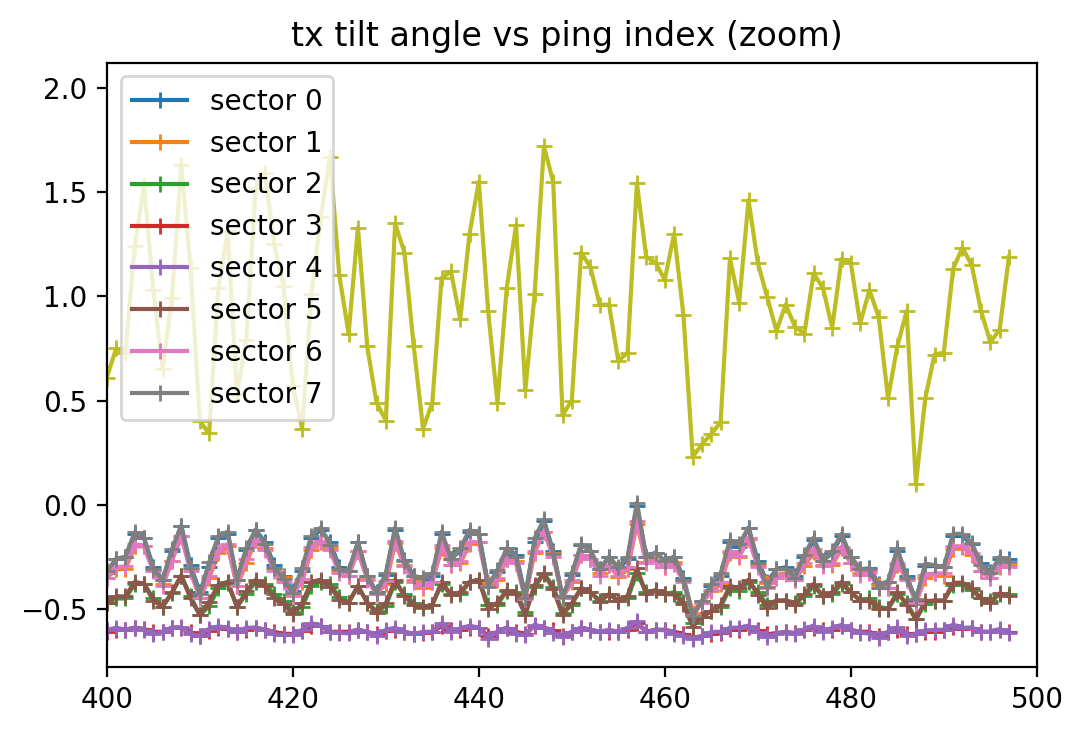

In [29]:

#Vérification des tx angle en fonction du pitch au moment d'emission
tx_tilt_angle=reader.get_variable(cst.BeamGroup1Grp.TX_BEAM_ROTATION_THETA())
pitch_atping_time= reader.get_variable(cst.BeamGroup1Grp.PLATFORM_PITCH())[:]
plt.legend(["sector "+str(i) for i in np.arange(0,tx_tilt_angle.shape[0])])

plt.xlim(400,500)
plt.title("tx tilt angle vs ping index (zoom) ")
tilts_per_tx=plt.plot(tx_tilt_angle,marker="+")
plt.legend(["sector "+str(i) for i in np.arange(0,tx_tilt_angle.shape[0])])
pitches=plt.plot(pitch_atping_time,marker="+")


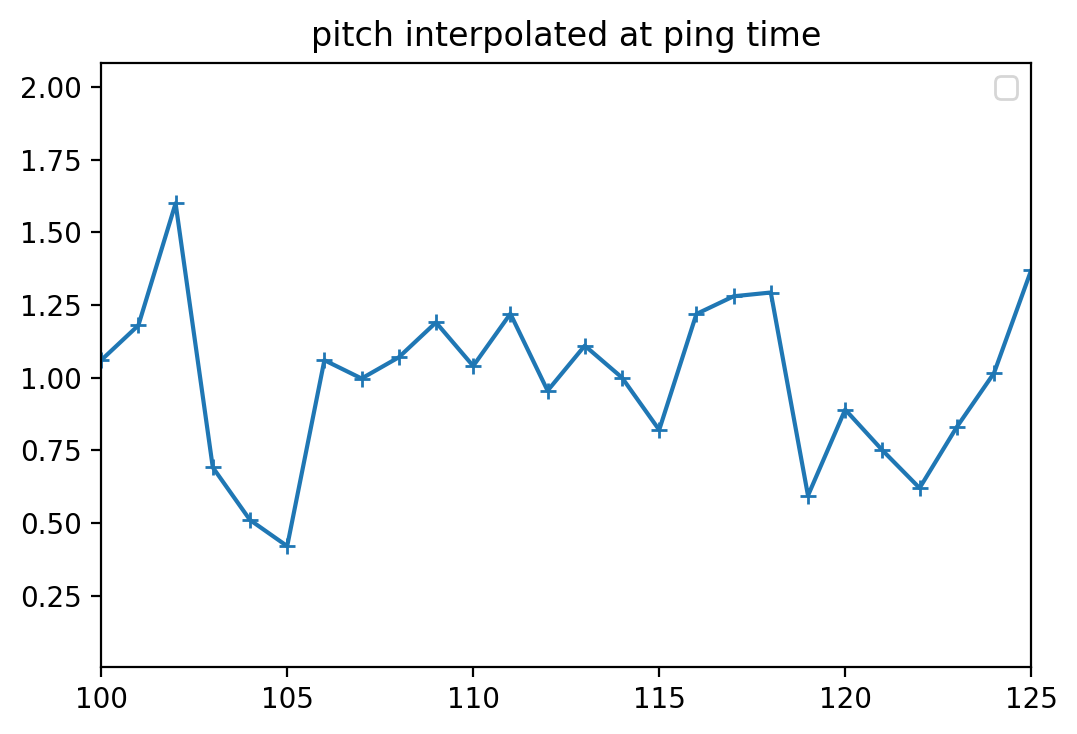

In [12]:
plt.legend(["sector "+str(i) for i in np.arange(0,tx_tilt_angle.shape[0])])
plt.xlim(100,125)
plt.title("pitch interpolated at ping time")
pitches=plt.plot(pitch_atping_time,marker="+")

Le tilt angle semble corrélé au pitch, toutefois on aurait pu s'attendre à une série de dépointage constants suivant les secteurs ce qui n'est pas le cas.  Visible vers le ping 115 notamment.


## Validation du passage tilt_ref_antenna à tilt_ref_vertical
Note : dans ce fichier la consigne est :

* No yaw stabilization

* Heading filter, medium

* Pitch stabilization is on
    
Et Tx along tilt:     0 (0.01 deg)


3.8184226e-08
[0 1]
tx installation pitch offset:0.64
Evaluate residu : median of tilt + pitch at ping time + pitch installation offset is 0.03300011157989502


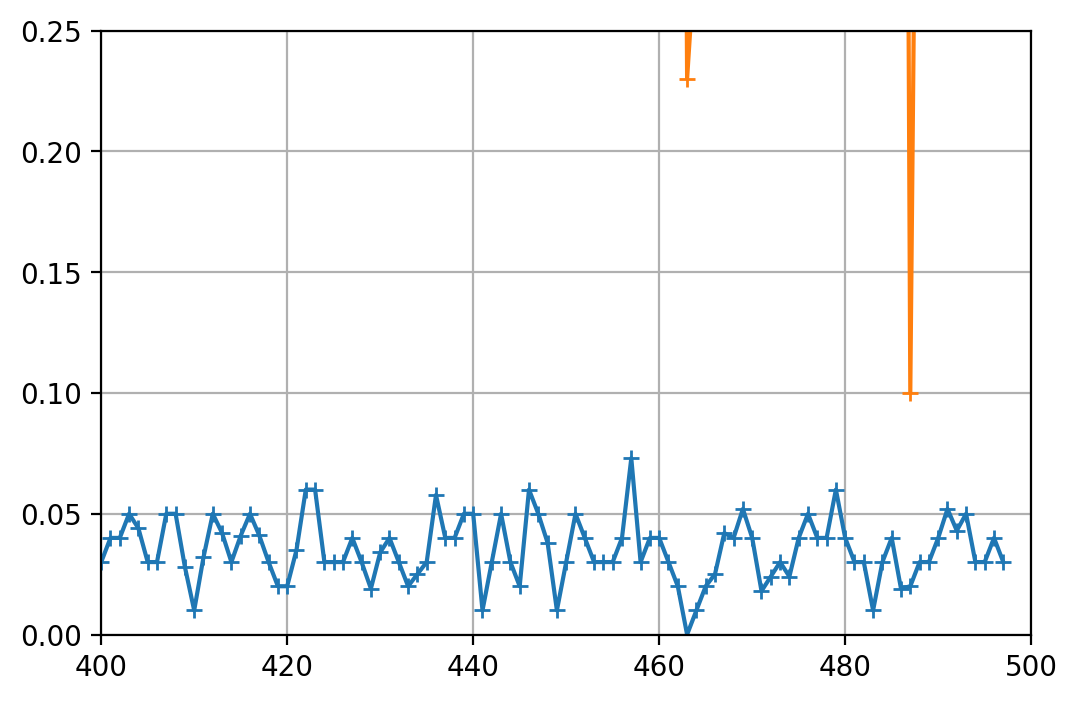

In [13]:

tx_tilt_angle_antenna=reader.get_variable(cst.BeamGroup1VendorSpecificGrp.RAW_TX_BEAM_TILT_ANGLE())

#on se concentre sur le central : 
tx_tilt_angle_ref_antenna = tx_tilt_angle_antenna[:,3]

#Approche brutale : on rajoute les angles d'installation de l'antenne en pitch ainsi que le pitch interpolé à l'instant d'émission

#on verifie que tx_time= ping_time
tx_time_offset_central= reader.get_variable(cst.BeamGroup1VendorSpecificGrp.TRANSMIT_TIME_DELAY())[:,3]
print(np.max(np.abs(tx_time_offset_central)))

installation_pitch_angles=reader.get_variable(cst.PlatformGrp.TRANSDUCER_ROTATION_Y())
transducers=reader.get_variable(cst.PlatformGrp.TRANSDUCER_FUNCTION())

print(transducers[:])
tx_indexes=np.where(transducers[:]==1)
tx_transducer_index=tx_indexes[0][0]
tx_pitch_offset_deg=reader.get_variable(cst.PlatformGrp.TRANSDUCER_ROTATION_Y())[tx_transducer_index]
print("tx installation pitch offset:" + str(tx_pitch_offset_deg))
compute_angle_ref_vertical= tx_tilt_angle_ref_antenna+pitch_atping_time+tx_pitch_offset_deg

plt.ylim(0,0.25)
plt.xlim(400,500)

plt.plot(compute_angle_ref_vertical,marker="+")
plt.plot(pitch_atping_time,marker="+")

plt.grid()
med=np.ma.median(compute_angle_ref_vertical)

print(f"Evaluate residu : median of tilt + pitch at ping time + pitch installation offset is {med}")

## On a un résidu de 0.033 deg entre le pitch et une valeur calculée pour un pitch à 0 par rapport à la verticale

MRU ids
['001' '002']


C:\Tools\Anaconda3\envs\pyat_dev\lib\site-packages\ipykernel_launcher.py:39: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


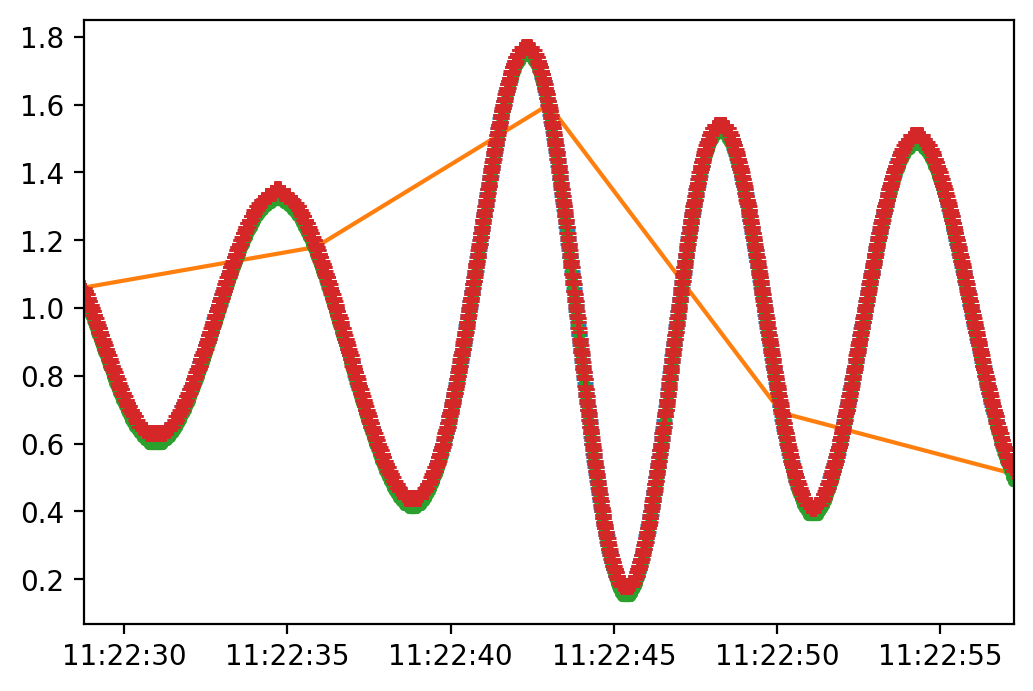

In [14]:
#This is a special case, we got two MRU
print("MRU ids")
MRU_names = reader.get_variable(cst.PlatformGrp.MRU_IDS())[:]
print(MRU_names)

active_MRU='001'
active_MRU2='002'

#estimation du pitch interpolé par rapport au pitch haute fréquence 
#retrieve High frequency data

hf_time= reader.get_variable(cst.AttitudeSubGroup.TIME(active_MRU))[:]
hf_pitch= reader.get_variable(cst.AttitudeSubGroup.PITCH(active_MRU))[:]
ping_time_zoomed=reader.get_variable(cst.BeamGroup1Grp.PING_TIME())[100:105]
pitch_atping_time_zoomed= reader.get_variable(cst.BeamGroup1Grp.PLATFORM_PITCH())[100:105]

min_hf_index = np.argmin(np.abs(hf_time-ping_time_zoomed[0]))
max_hf_index = np.argmin(np.abs(ping_time_zoomed[-1]-hf_time))
hf_time=hf_time[min_hf_index:max_hf_index:]
hf_pitch = hf_pitch[min_hf_index:max_hf_index:]
plt.xlim(nano_todatetime(hf_time[0]),nano_todatetime(hf_time[-1]))
plt.plot(nano_todatetime(hf_time),hf_pitch, label='high frequency pitch',marker="+")
plt.plot(nano_todatetime(ping_time_zoomed),pitch_atping_time_zoomed, label='high frequency pitch',marker="+")


hf_time= reader.get_variable(cst.AttitudeSubGroup.TIME(active_MRU2))[:]
hf_pitch= reader.get_variable(cst.AttitudeSubGroup.PITCH(active_MRU2))[:]
min_hf_index = np.argmin(np.abs(hf_time-ping_time_zoomed[0]))
max_hf_index = np.argmin(np.abs(ping_time_zoomed[-1]-hf_time))
hf_time=hf_time[min_hf_index:max_hf_index:]
hf_pitch = hf_pitch[min_hf_index:max_hf_index:]
plt.plot(nano_todatetime(hf_time),hf_pitch, label='high frequency pitch 001',marker=".")

pitch_network = reader.get_variable(cst.NetworkAttitudeVelocity110Grp.PITCH(active_MRU))
time_network= reader.get_variable(cst.NetworkAttitudeVelocity110Grp.DATAGRAM_TIME(active_MRU))[:]
min_hf_index = np.argmin(np.abs(time_network-ping_time_zoomed[0]))
max_hf_index = np.argmin(np.abs(ping_time_zoomed[-1]-time_network))
hf_time=time_network[min_hf_index:max_hf_index:]
hf_pitch = pitch_network[min_hf_index:max_hf_index:]
plt.plot(nano_todatetime(hf_time),hf_pitch, label='network pitch 001',marker="+")



# Note : il y a une telle résolution en echantillonnage de pitch que l'utilisation d'interpolation pour évaluer un pitch à chaque instant du ping n'a pas de sens.  Par contre cela n'explique ni les écarts ci dessus ni les variations au cours du temps.

## Nouvelle hypothèse : la première approche consistait naivement à additionner les angles. Voir si sondeur prend en compte les bras de levier de l'équipement.

In [15]:
from scipy.spatial.transform import Rotation

x=reader.get_variable(cst.PlatformGrp.TRANSDUCER_OFFSET_X())[tx_transducer_index]
y=reader.get_variable(cst.PlatformGrp.TRANSDUCER_OFFSET_Y())[tx_transducer_index]
z=reader.get_variable(cst.PlatformGrp.TRANSDUCER_OFFSET_Z())[tx_transducer_index]

tx_installation_translation=[float(x),float(y),float(z)]
#for debug
#tx_installation_translation= [0 , 0 , 0]

print(f"tx installation offset: {tx_installation_translation}")
tx_rot_z=reader.get_variable(cst.PlatformGrp.TRANSDUCER_ROTATION_Z())[tx_transducer_index]
tx_rot_y=reader.get_variable(cst.PlatformGrp.TRANSDUCER_ROTATION_Y())[tx_transducer_index]
tx_rot_x=reader.get_variable(cst.PlatformGrp.TRANSDUCER_ROTATION_X())[tx_transducer_index]
tx_installation_rot=Rotation.from_euler("zyx",(tx_rot_z,tx_rot_y,tx_rot_x),degrees=True)
print(f"installation_tx_rot: {tx_installation_rot.as_euler('zyx', degrees=True)}" )
#let's consider one single ping
ping_index=105
heading=reader.get_variable(cst.BeamGroup1Grp.PLATFORM_HEADING())[:]
pitch=reader.get_variable(cst.BeamGroup1Grp.PLATFORM_PITCH())[:]
roll=reader.get_variable(cst.BeamGroup1Grp.PLATFORM_ROLL())[:]

navigation_attitude_rot=Rotation.from_euler("zyx",(0,pitch[ping_index],roll[ping_index]),degrees=True)
#for debug
#navigation_attitude_rot=Rotation.from_euler("zyx",(0,pitch[ping_index],0),degrees=True)
print(f"platform attitude for ping {ping_index}: {navigation_attitude_rot.as_euler('zyx', degrees=True)}" )


tx installation offset: [3.434000015258789, 4.139999866485596, 8.348999977111816]
installation_tx_rot: [-0.10998535  0.63999999  0.        ]
platform attitude for ping 105: [ 0.          0.41999999 -0.70999998]


In [16]:
#Let's consider a vector at bottom beneath the ship (3300m)
#get focus range 
reader.dataset.set_auto_maskandscale(False)
focus_ranges=reader.get_variable(cst.BeamGroup1VendorSpecificGrp.FOCUS_RANGE())[:,3]
focus_ranges=focus_ranges*0.1
reader.dataset.set_auto_maskandscale(False)
focus=focus_ranges[ping_index]

vec=[3.434000015258789,4.139999866485596,focus]
print(f"Considered vector {vec}")
#its position in antenna should be 
tmp=np.dot(tx_installation_rot.inv().as_dcm(),vec)-tx_installation_translation
vec_ref_antenna=np.dot(navigation_attitude_rot.inv().as_dcm(),tmp)


Considered vector [3.434000015258789, 4.139999866485596, 3314.1000000000004]


In [17]:
print(vec_ref_antenna)

[ -61.25428847  -41.02566483 3304.96779449]


In [18]:
computed_tilt=np.degrees(np.arctan2(vec_ref_antenna[0],vec_ref_antenna[2]))

In [19]:
print(f"computed angle {computed_tilt}")

computed angle -1.0617986757233855


In [20]:
print(f"SUM OF TILTS {tx_rot_y+pitch[ping_index]}")

SUM OF TILTS 1.059999942779541


In [21]:
#print expected value
print(f"Expected central tilt angle {tx_tilt_angle_ref_antenna[ping_index]}")

Expected central tilt angle -1.0399999618530273


## Si on prend en compte les bras de levier, et que l'on essaye d'estimer un angle sans tenir compte du profil de célérité, on a un écart plus élévé que la simple addition des deux angles installation + attitude


## Hypothèse : Est ce que l'on anticiperait l'avancée du bateau ? ie rajouter un tilt en fonction de la vitesse, profondeur et ping rate

<Figure size 1200x800 with 0 Axes>

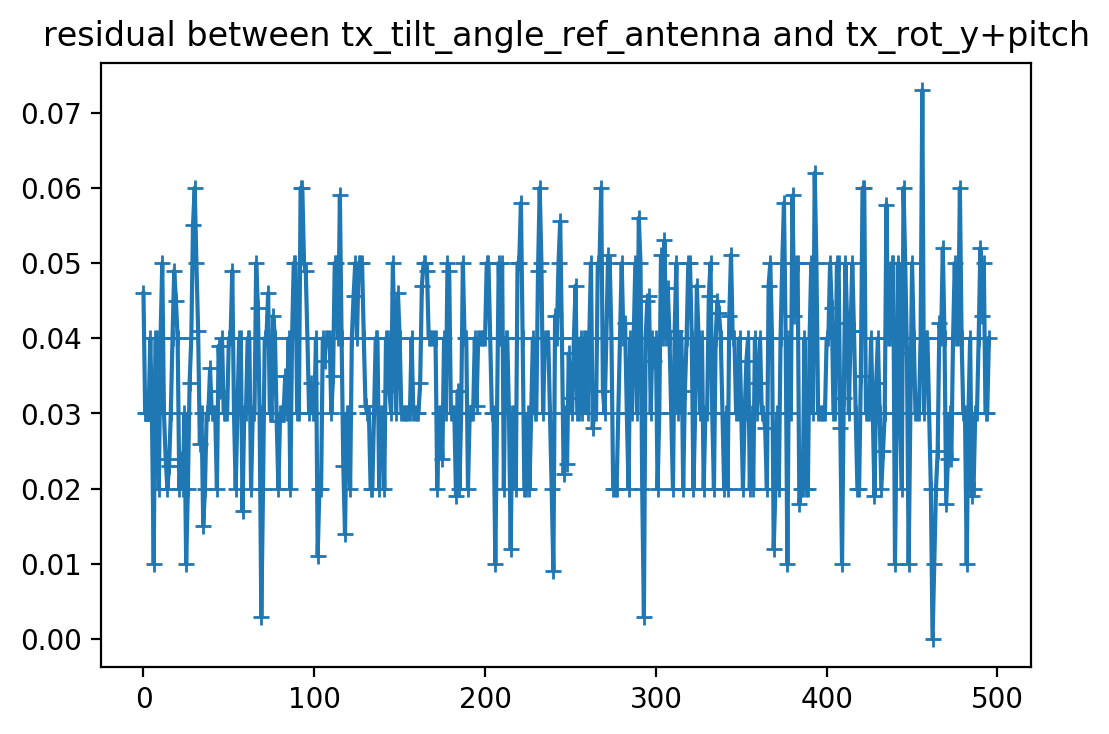

<Figure size 1200x800 with 0 Axes>

In [22]:
diff=tx_rot_y+pitch[:]+tx_tilt_angle_ref_antenna[:]
plt.title("residual between tx_tilt_angle_ref_antenna and tx_rot_y+pitch")
plt.plot(diff[1:-1],marker="+")
plt.figure()


la valeur moyenne est de l'ordre de 0.03

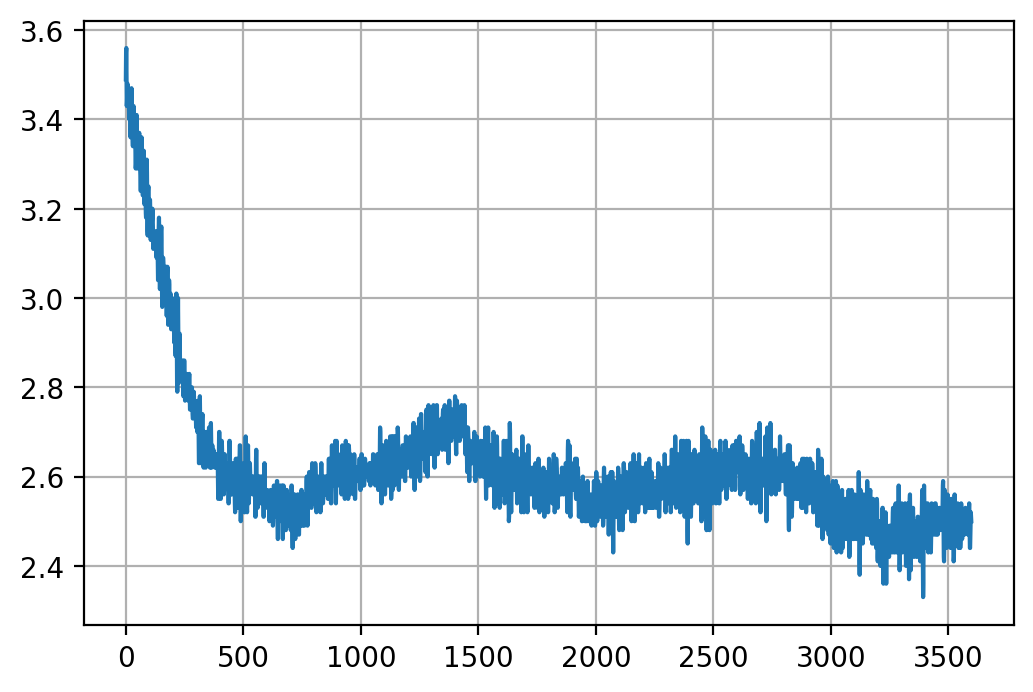

In [23]:
#on regarde si c'est corrélé à la vitesse
speed=reader.get_variable(cst.PositionSubGroup.SPEED_OVER_GROUND("000"))[:]
plt.plot(speed)
plt.grid()

## A priori on a pas l'air d'anticiper le déplacement du bateau, les données ne sont pas corrélées

### Pour info empreinte au sol des secteurs pour un ping 

Text(0.5, 1.0, 'detection position for ping 105')

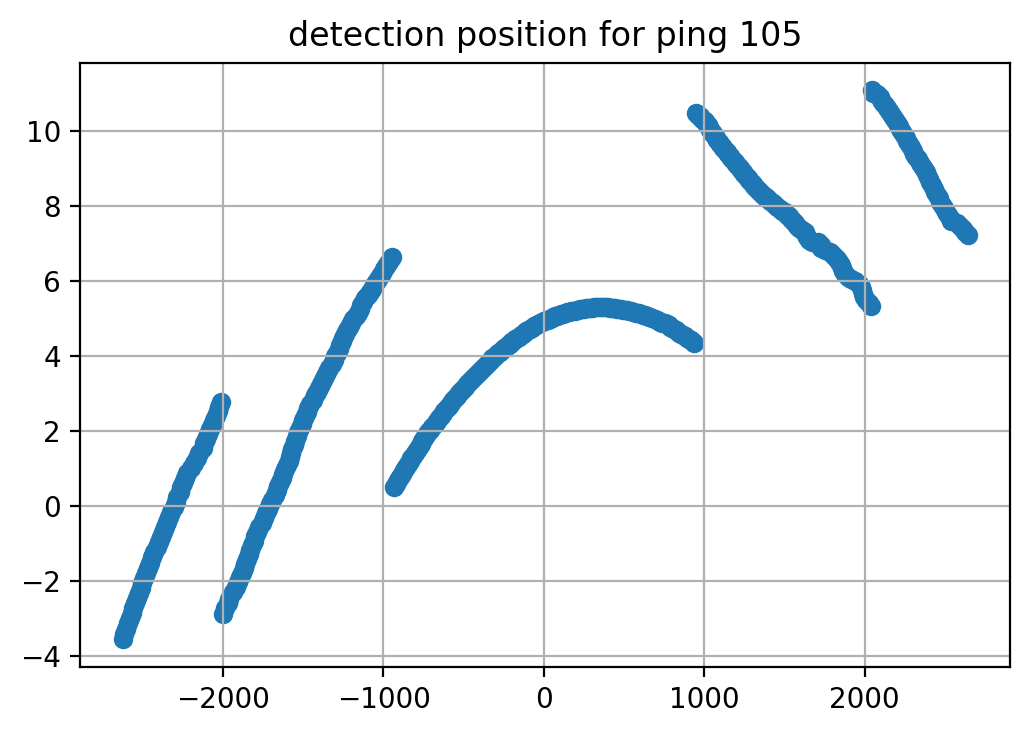

In [25]:
detection_x=reader.get_variable(cst.BathymetryGrp.DETECTION_X())[ping_index,:]
detection_y=reader.get_variable(cst.BathymetryGrp.DETECTION_Y())[ping_index,:]
plt.figure()

plt.scatter(detection_y,detection_x)
plt.grid()
plt.title(f"detection position for ping {ping_index}")